Group 9  
DSA 4158 – Principles of Big Data

Task 1 - Reproducible setup (Spark + folders)

Task 1.1 - Initialize Spark

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[2]") \
    .appName("9_BaccayCabaelleroOlaybar_Preprocessing") \
    .config("spark.driver.memory", "1g") \
    .config("spark.sql.shuffle.partitions", "4") \
    .getOrCreate()

spark

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/02/16 15:00:01 WARN Utils: Your hostname, JoJo, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
26/02/16 15:00:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/16 15:00:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Task 1.2 - Print Spark Info

In [2]:
print("Spark Version:", spark.version)
print("Spark Master:", spark.sparkContext.master)
print("Spark UI URL:", spark.sparkContext.uiWebUrl)

conf = spark.sparkContext.getConf()
print("Driver Memory:", conf.get("spark.driver.memory"))
print("Shuffle Partitions:", spark.conf.get("spark.sql.shuffle.partitions"))

Spark Version: 4.1.1
Spark Master: local[2]
Spark UI URL: http://10.255.255.254:4040
Driver Memory: 1g
Shuffle Partitions: 4


Task 1.3 - Create Folder Structure (Run in WSL Terminal)

Task 2 - Splitting the “large” CSV

Task 3 - Scalable ingestion in Spark

In [3]:
from pyspark.sql import functions as F

base = "/home/john/bigdata_project/bigdata/bigdata_project/opendota_processed/9/matches_parts"

df = spark.read \
    .option("header", True) \
    .option("encoding", "UTF-16") \
    .csv(base)

df.select("match_id","start_time","duration","radiant_win").limit(5).show()

+----------+----------+--------+-----------+
|  match_id|start_time|duration|radiant_win|
+----------+----------+--------+-----------+
|         �|      NULL|    NULL|       NULL|
|1810437348|1442861591|    3901|          f|
|         �|      NULL|    NULL|       NULL|
|  40151662|1347462022|    2160|          t|
|         �|      NULL|    NULL|       NULL|
+----------+----------+--------+-----------+



Task 4 - Data Cleaning

Task 4.1 - Label Types

In [4]:
matches_clean = df.select(
    F.expr("try_cast(match_id as bigint)").alias("match_id"),
    F.expr("try_cast(start_time as bigint)").alias("start_time"),
    F.expr("try_cast(duration as int)").alias("duration"),
    F.expr("try_cast(radiant_win as boolean)").alias("radiant_win")
)

Task 4.2 - Before vs After Counts

In [5]:
print("Before Cleaning:", df.count())

matches_clean = matches_clean.filter(F.col("match_id").isNotNull())

print("After Null Removal:", matches_clean.count())

Before Cleaning: 1000010


[Stage 5:========================================================>(69 + 1) / 70]

After Null Removal: 500000


Task 4.3 - Drop Duplicates

In [6]:
matches_clean = matches_clean.dropDuplicates(["match_id"])

Task 4.4 - Filter Unreasonable Durations

In [7]:
matches_clean = matches_clean.filter(
    (F.col("duration") > 300) & 
    (F.col("duration") < 7200)
)

In [8]:
matches_clean.show(5)

[Stage 8:========================================================>(69 + 1) / 70]

+----------+----------+--------+-----------+
|  match_id|start_time|duration|radiant_win|
+----------+----------+--------+-----------+
|1810437348|1442861591|    3901|      false|
|2157263842|1455665899|    3501|       true|
| 652858102|1399737612|    3444|      false|
|1810437480|1442861586|    2066|       true|
|1810437510|1442861591|    2298|      false|
+----------+----------+--------+-----------+
only showing top 5 rows


Task 5 - Data Transformation

Task 5.1 - Convert Epoch to Timestamp

In [9]:
matches_features = matches_clean.withColumn(
    "start_ts",
    F.from_unixtime("start_time").cast("timestamp")
)

Task 5.2 - Derive Dates

In [10]:
matches_features = matches_features \
    .withColumn("year", F.year("start_ts")) \
    .withColumn("month", F.month("start_ts"))

Task 5.3 - Duration in Minutes

In [11]:
matches_features = matches_features.withColumn(
    "duration_min",
    F.col("duration") / 60
)

Task 5.4 - Duration Bins

In [12]:
matches_features = matches_features.withColumn(
    "duration_bin",
    F.when(F.col("duration_min") < 20, "<20")
     .when((F.col("duration_min") >= 20) & (F.col("duration_min") < 30), "20-30")
     .when((F.col("duration_min") >= 30) & (F.col("duration_min") < 40), "30-40")
     .otherwise("40+")
)

In [13]:
matches_features.show(5)

[Stage 11:=======================================================>(69 + 1) / 70]

+----------+----------+--------+-----------+-------------------+----+-----+-----------------+------------+
|  match_id|start_time|duration|radiant_win|           start_ts|year|month|     duration_min|duration_bin|
+----------+----------+--------+-----------+-------------------+----+-----+-----------------+------------+
|1810437348|1442861591|    3901|      false|2015-09-22 02:53:11|2015|    9|65.01666666666667|         40+|
|2157263842|1455665899|    3501|       true|2016-02-17 07:38:19|2016|    2|            58.35|         40+|
| 652858102|1399737612|    3444|      false|2014-05-11 00:00:12|2014|    5|             57.4|         40+|
|1810437480|1442861586|    2066|       true|2015-09-22 02:53:06|2015|    9|34.43333333333333|       30-40|
|1810437510|1442861591|    2298|      false|2015-09-22 02:53:11|2015|    9|             38.3|       30-40|
+----------+----------+--------+-----------+-------------------+----+-----+-----------------+------------+
only showing top 5 rows


Task 6 - Data Reduction

In [14]:
output_path = "/home/john/bigdata_project/bigdata/bigdata_project/opendota_processed/9/data/matches_parquet"

matches_features.write \
    .mode("overwrite") \
    .partitionBy("year", "month") \
    .parquet(output_path)

In [15]:
ls -R ~/bigdata_project/bigdata/bigdata_project/opendota_processed/9/data

/home/john/bigdata_project/bigdata/bigdata_project/opendota_processed/9/data:
activity_summary/  eda_duration_distribution/  eda_win_rate_trend/
eda_activity/      eda_duration_trend/         matches_parquet/

/home/john/bigdata_project/bigdata/bigdata_project/opendota_processed/9/data/activity_summary:
_SUCCESS  part-00000-4783fe84-7781-4a1c-bbd9-12388d79dadd-c000.csv

/home/john/bigdata_project/bigdata/bigdata_project/opendota_processed/9/data/eda_activity:
_SUCCESS  part-00000-58a893e4-b2ee-4ee4-86b2-72e197b86321-c000.snappy.parquet

/home/john/bigdata_project/bigdata/bigdata_project/opendota_processed/9/data/eda_duration_distribution:
_SUCCESS  part-00000-6a2db7c3-149a-4f18-a1bd-e0d3551191aa-c000.snappy.parquet

/home/john/bigdata_project/bigdata/bigdata_project/opendota_processed/9/data/eda_duration_trend:
_SUCCESS  part-00000-24b6ed06-fcd6-4402-a0be-0f20c9e37066-c000.snappy.parquet

/home/john/bigdata_project/bigdata/bigdata_project/opendota_processed/9/data/eda_win_rate_trend:
_

In [16]:
spark.read.parquet(output_path) \
    .filter(F.col("year") == 2016) \
    .explain(True)

== Parsed Logical Plan ==
'Filter '`=`('year, 2016)
+- Relation [match_id#260L,start_time#261L,duration#262,radiant_win#263,start_ts#264,duration_min#265,duration_bin#266,year#267,month#268] parquet

== Analyzed Logical Plan ==
match_id: bigint, start_time: bigint, duration: int, radiant_win: boolean, start_ts: timestamp, duration_min: double, duration_bin: string, year: int, month: int
Filter (year#267 = 2016)
+- Relation [match_id#260L,start_time#261L,duration#262,radiant_win#263,start_ts#264,duration_min#265,duration_bin#266,year#267,month#268] parquet

== Optimized Logical Plan ==
Filter (isnotnull(year#267) AND (year#267 = 2016))
+- Relation [match_id#260L,start_time#261L,duration#262,radiant_win#263,start_ts#264,duration_min#265,duration_bin#266,year#267,month#268] parquet

== Physical Plan ==
*(1) ColumnarToRow
+- FileScan parquet [match_id#260L,start_time#261L,duration#262,radiant_win#263,start_ts#264,duration_min#265,duration_bin#266,year#267,month#268] Batched: true, DataFilt

Task 7 - EDA

Task 7.1 - Match Activity Over Time

In [17]:
activity = matches_features.groupBy("year","month") \
    .agg(F.count("*").alias("match_count")) \
    .orderBy("year","month")

activity.show()

[Stage 20:===================>                                      (1 + 2) / 3]

+----+-----+-----------+
|year|month|match_count|
+----+-----+-----------+
|2011|    7|          7|
|2011|    9|          2|
|2011|   10|         19|
|2011|   11|         34|
|2011|   12|         96|
|2012|    1|        168|
|2012|    2|        383|
|2012|    3|        297|
|2012|    4|        524|
|2012|    5|        511|
|2012|    6|        607|
|2012|    7|        761|
|2012|    8|       3534|
|2012|    9|       2068|
|2012|   10|       1127|
|2012|   11|       1524|
|2012|   12|       1786|
|2013|    1|       1568|
|2013|    2|       1282|
|2013|    3|       5682|
+----+-----+-----------+
only showing top 20 rows


In [18]:
activity.write.mode("overwrite").parquet(
    "/home/john/bigdata_project/bigdata/bigdata_project/opendota_processed/9/data/eda_activity"
)

Task 7.2 - Average Duration Trend

In [19]:
duration_trend = matches_features.groupBy("year","month") \
    .agg(F.round(F.avg("duration_min"),2).alias("avg_duration_min")) \
    .orderBy("year","month")

duration_trend.show()

[Stage 39:===================>                                      (1 + 2) / 3]

+----+-----+----------------+
|year|month|avg_duration_min|
+----+-----+----------------+
|2011|    7|            48.8|
|2011|    9|           18.22|
|2011|   10|            41.3|
|2011|   11|            37.1|
|2011|   12|            41.0|
|2012|    1|           41.88|
|2012|    2|           38.41|
|2012|    3|            40.8|
|2012|    4|           40.44|
|2012|    5|           40.83|
|2012|    6|           38.96|
|2012|    7|           39.72|
|2012|    8|           39.79|
|2012|    9|            39.5|
|2012|   10|           38.95|
|2012|   11|           34.12|
|2012|   12|           34.41|
|2013|    1|           38.07|
|2013|    2|           38.67|
|2013|    3|           38.84|
+----+-----+----------------+
only showing top 20 rows


In [20]:
duration_trend.write.mode("overwrite").parquet(
    "/home/john/bigdata_project/bigdata/bigdata_project/opendota_processed/9/data/eda_duration_trend"
)

In [21]:
duration_distribution = matches_features.groupBy("duration_bin") \
    .agg(F.count("*").alias("match_count")) \
    .orderBy("duration_bin")

duration_distribution.show()

[Stage 56:=======================================================>(69 + 1) / 70]

+------------+-----------+
|duration_bin|match_count|
+------------+-----------+
|       20-30|      56290|
|       30-40|     162962|
|         40+|     264758|
|         <20|      13283|
+------------+-----------+



In [22]:
duration_distribution.write.mode("overwrite").parquet(
    "/home/john/bigdata_project/bigdata/bigdata_project/opendota_processed/9/data/eda_duration_distribution"
)

Task 7.4 Are win rates stable over time?

In [23]:
win_rate_trend = matches_features.groupBy("year","month") \
    .agg(
        F.count("*").alias("match_count"),
        F.round(F.avg(F.col("radiant_win").cast("int")),3).alias("radiant_win_rate")
    ) \
    .orderBy("year","month")

win_rate_trend.show()

[Stage 77:======================================>                   (2 + 1) / 3]

+----+-----+-----------+----------------+
|year|month|match_count|radiant_win_rate|
+----+-----+-----------+----------------+
|2011|    7|          7|           0.143|
|2011|    9|          2|             1.0|
|2011|   10|         19|           0.684|
|2011|   11|         34|           0.441|
|2011|   12|         96|           0.604|
|2012|    1|        168|           0.476|
|2012|    2|        383|           0.514|
|2012|    3|        297|           0.519|
|2012|    4|        524|           0.559|
|2012|    5|        511|           0.534|
|2012|    6|        607|           0.502|
|2012|    7|        761|           0.514|
|2012|    8|       3534|           0.527|
|2012|    9|       2068|           0.539|
|2012|   10|       1127|           0.523|
|2012|   11|       1524|           0.364|
|2012|   12|       1786|           0.537|
|2013|    1|       1568|           0.529|
|2013|    2|       1282|           0.527|
|2013|    3|       5682|           0.513|
+----+-----+-----------+----------

The Radiant win rate remains relatively stable around 50–53% across most months, suggesting no strong systemic imbalance over time. Early years show volatility due to small sample sizes.

In [24]:
win_rate_trend.write.mode("overwrite").parquet(
    "/home/john/bigdata_project/bigdata/bigdata_project/opendota_processed/9/data/eda_win_rate_trend"
)

Task 8 - Visualization

Task 8.1 Static(matplotlib)

Match Activity Over Time

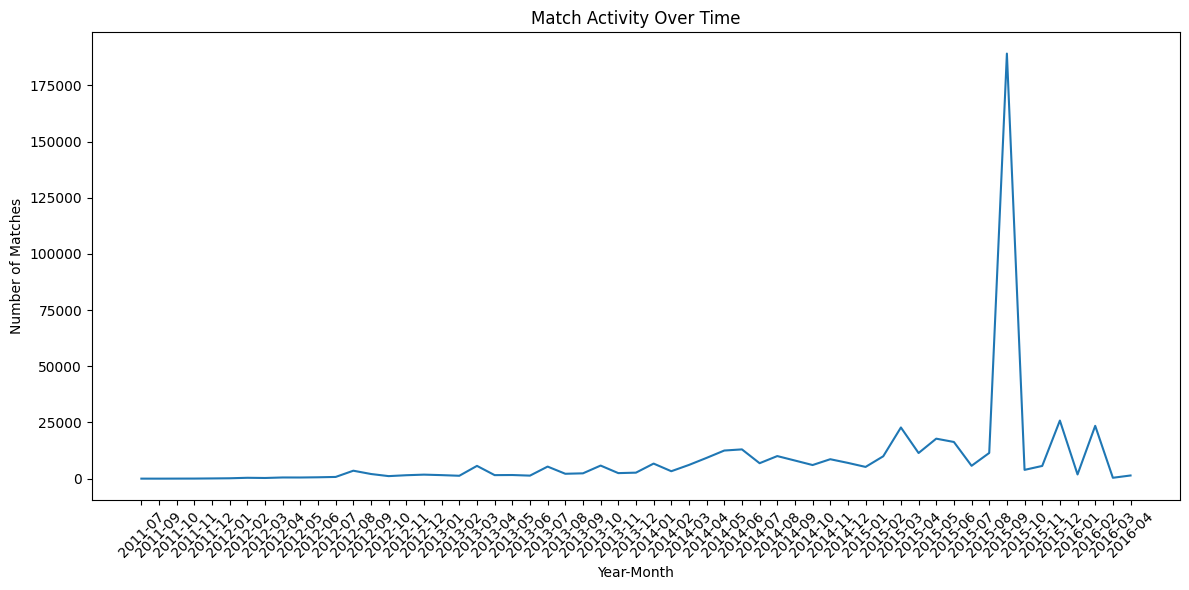

In [25]:
import matplotlib.pyplot as plt

activity_pd = activity.toPandas()

activity_pd["year_month"] = (
    activity_pd["year"].astype(str) + "-" +
    activity_pd["month"].astype(str).str.zfill(2)
)

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(activity_pd["year_month"], activity_pd["match_count"])  # FIXED HERE

ax.set_title("Match Activity Over Time")
ax.set_xlabel("Year-Month")
ax.set_ylabel("Number of Matches")

plt.xticks(rotation=45)
plt.tight_layout()

fig.savefig("/home/john/bigdata_project/bigdata/bigdata_project/opendota_processed/9/figures/activity.png")

plt.show()
plt.close()

In [26]:
print(activity_pd.columns)

Index(['year', 'month', 'match_count', 'year_month'], dtype='str')


Average Duration Trend

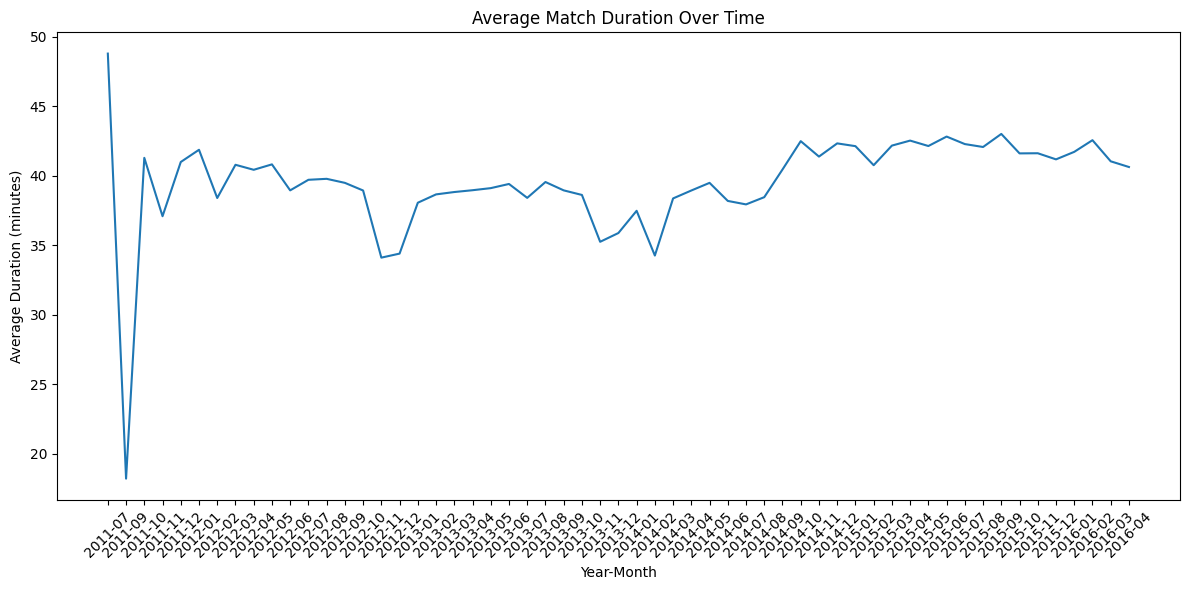

In [30]:
duration_pd["year_month"] = (
    duration_pd["year"].astype(str) + "-" +
    duration_pd["month"].astype(str).str.zfill(2)
)

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(duration_pd["year_month"], duration_pd["avg_duration_min"])

ax.set_title("Average Match Duration Over Time")
ax.set_xlabel("Year-Month")
ax.set_ylabel("Average Duration (minutes)")

plt.xticks(rotation=45)
plt.tight_layout()

fig.savefig("/home/john/bigdata_project/bigdata/bigdata_project/opendota_processed/9/figures/duration_trend.png")

plt.show()
plt.close()

Duration Bin Distribution

In [34]:
print(duration_bin.columns)

NameError: name 'duration_bin' is not defined

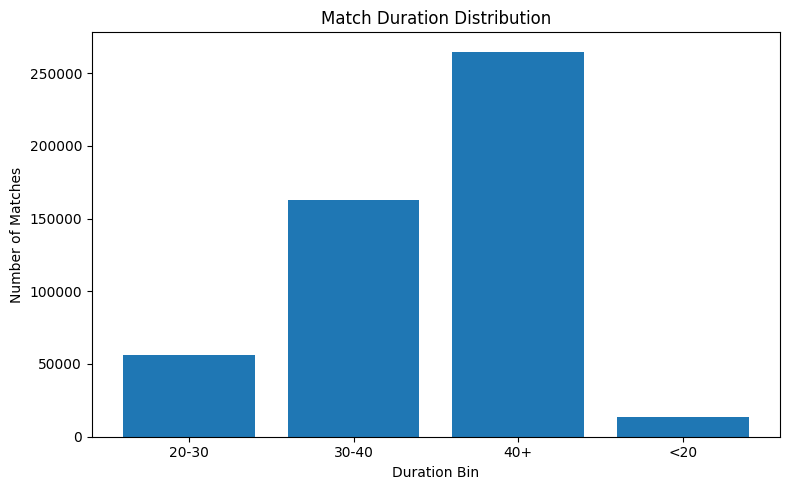

In [33]:
bins_pd = duration_distribution.toPandas()

plt.figure(figsize=(8,5))
plt.bar(bins_pd["duration_bin"], bins_pd["match_count"])

plt.title("Match Duration Distribution")
plt.xlabel("Duration Bin")
plt.ylabel("Number of Matches")

plt.tight_layout()
plt.savefig("/home/john/bigdata_project/bigdata/bigdata_project/opendota_processed/9/figures/duration_bins.png")
plt.show()
plt.close()

Win Rates Stablity

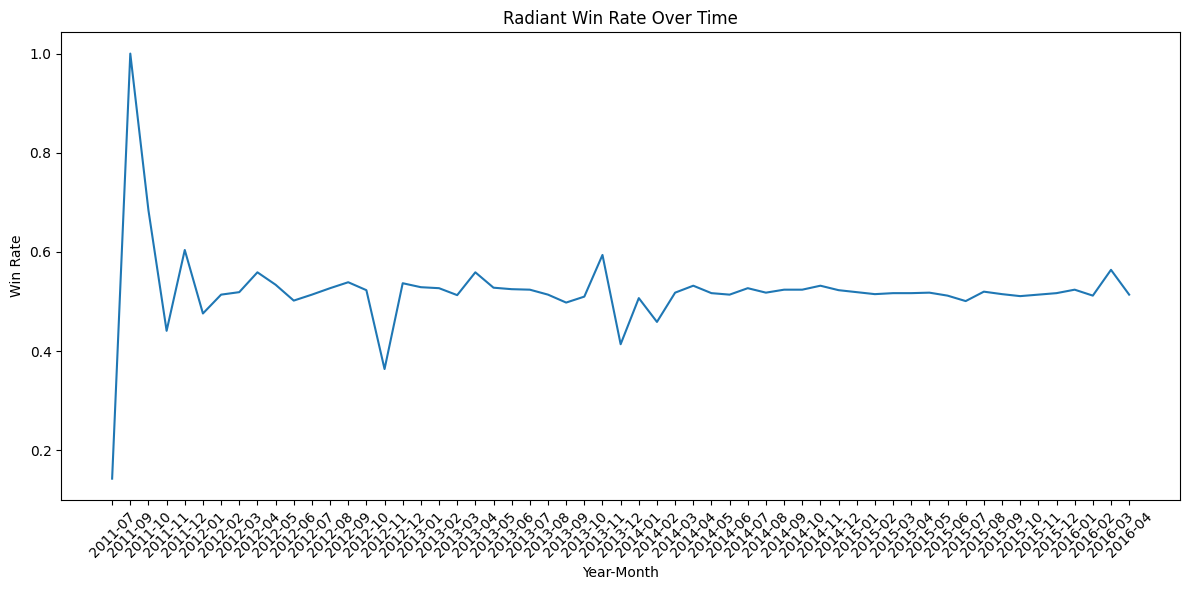

In [41]:
win_rate_pd = win_rate_trend.toPandas()

win_rate_pd["year_month"] = (
    win_rate_pd["year"].astype(str) + "-" +
    win_rate_pd["month"].astype(str).str.zfill(2)
)

plt.figure(figsize=(12,6))
plt.plot(win_rate_pd["year_month"], win_rate_pd["radiant_win_rate"])

plt.xticks(rotation=45)
plt.title("Radiant Win Rate Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Win Rate")
plt.tight_layout()

plt.savefig("/home/john/bigdata_project/bigdata/bigdata_project/opendota_processed/9/figures/win_rate.png")

plt.show()
plt.close()

Task 8.2 Interactive(plotly)

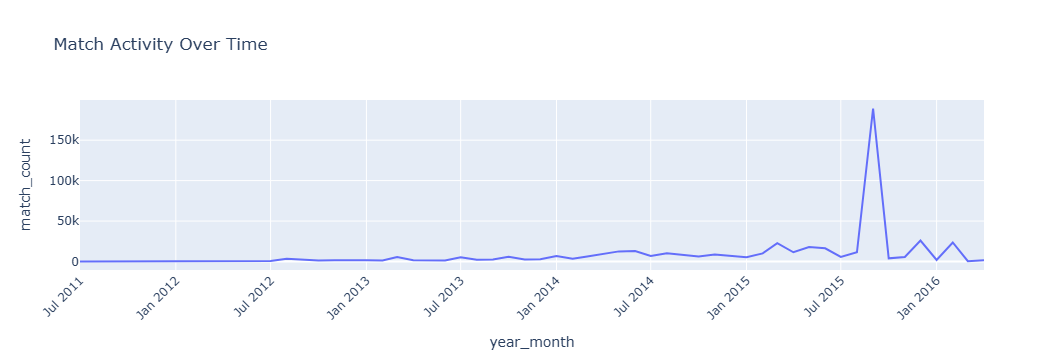

In [43]:
import plotly.express as px

fig = px.line(
    activity_pd,
    x="year_month",
    y="match_count",
    title="Match Activity Over Time"
)

fig.update_layout(xaxis_tickangle=-45)
fig.show()

MapReduce

In [44]:
# MAP → each row implicitly emits:
# key = (year, month)
# value = (1, duration_min, radiant_win)

mapreduce_df = matches_features.groupBy("year", "month") \
    .agg(
        F.count("*").alias("match_count"),
        F.avg("duration_min").alias("avg_duration"),
        F.avg(F.col("radiant_win").cast("int")).alias("win_rate")
    ) \
    .orderBy("year", "month")

mapreduce_df.show(10)

[Stage 152:======================================>                  (2 + 1) / 3]

+----+-----+-----------+------------------+-------------------+
|year|month|match_count|      avg_duration|           win_rate|
+----+-----+-----------+------------------+-------------------+
|2011|    7|          7| 48.80238095238095|0.14285714285714285|
|2011|    9|          2|18.216666666666665|                1.0|
|2011|   10|         19| 41.30438596491228| 0.6842105263157895|
|2011|   11|         34|  37.0985294117647| 0.4411764705882353|
|2011|   12|         96| 40.99843750000001| 0.6041666666666666|
|2012|    1|        168| 41.87936507936508|0.47619047619047616|
|2012|    2|        383| 38.40735422106178| 0.5143603133159269|
|2012|    3|        297|40.799551066217724| 0.5185185185185185|
|2012|    4|        524| 40.43613231552164| 0.5591603053435115|
|2012|    5|        511|40.826320939334636| 0.5342465753424658|
+----+-----+-----------+------------------+-------------------+
only showing top 10 rows


Physical Plan

In [45]:
mapreduce_df.explain(True)

== Parsed Logical Plan ==
'Sort ['year ASC NULLS FIRST, 'month ASC NULLS FIRST], true
+- Aggregate [year#160, month#161], [year#160, month#161, count(1) AS match_count#834L, avg(duration_min#162) AS avg_duration#835, avg(cast(radiant_win#71 as int)) AS win_rate#836]
   +- Project [match_id#68L, start_time#69L, duration#70, radiant_win#71, start_ts#159, year#160, month#161, duration_min#162, CASE WHEN (duration_min#162 < cast(20 as double)) THEN <20 WHEN ((duration_min#162 >= cast(20 as double)) AND (duration_min#162 < cast(30 as double))) THEN 20-30 WHEN ((duration_min#162 >= cast(30 as double)) AND (duration_min#162 < cast(40 as double))) THEN 30-40 ELSE 40+ END AS duration_bin#163]
      +- Project [match_id#68L, start_time#69L, duration#70, radiant_win#71, start_ts#159, year#160, month#161, (cast(duration#70 as double) / cast(60 as double)) AS duration_min#162]
         +- Project [match_id#68L, start_time#69L, duration#70, radiant_win#71, start_ts#159, year#160, month(cast(start_ts

26/02/16 15:41:21 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Save a small part

In [46]:
mapreduce_df.write.mode("overwrite") \
    .option("header", True) \
    .csv("/home/john/bigdata_project/bigdata/bigdata_project/opendota_processed/9/data/activity_summary")

Mapreduce Diagram

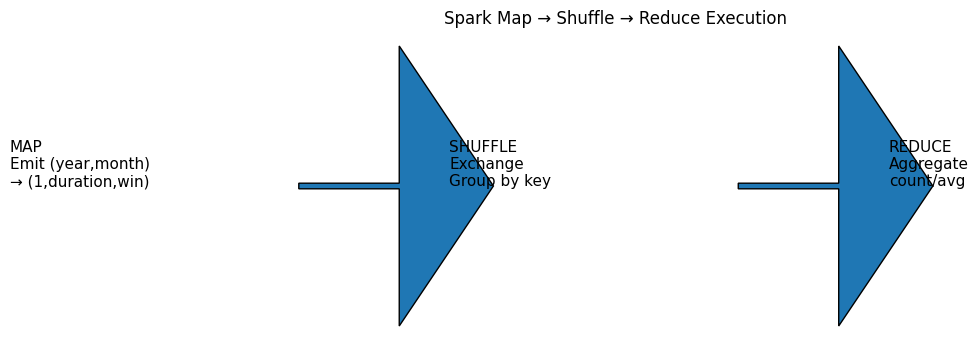

In [47]:
plt.figure(figsize=(9,4))

plt.text(0.05, 0.5, "MAP\nEmit (year,month)\n→ (1,duration,win)", fontsize=11)
plt.text(0.4, 0.5, "SHUFFLE\nExchange\nGroup by key", fontsize=11)
plt.text(0.75, 0.5, "REDUCE\nAggregate\ncount/avg", fontsize=11)

plt.arrow(0.28, 0.5, 0.08, 0, head_width=0.05)
plt.arrow(0.63, 0.5, 0.08, 0, head_width=0.05)

plt.axis("off")
plt.title("Spark Map → Shuffle → Reduce Execution")

plt.savefig("/home/john/bigdata_project/bigdata/bigdata_project/opendota_processed/9/figures/Mapreduce_diagram.png")
plt.show()

Spark UI

In [48]:
print("Spark UI:", spark.sparkContext.uiWebUrl)

Spark UI: http://10.255.255.254:4040


http://localhost:4040